In [14]:
import MySQLdb as db
import pandas as pd
import numpy as np
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
name = 'DatabaseMain'
conn = db.connect(host = "localhost", user = "root", passwd ="", db=name)
cursor = conn.cursor()

sql = ''' SELECT G.DateTime, W.Room, R.Capacity, T.Module, M.NumReg, W.Associated, G.PercentageEstimate, G.BinaryEstimate
          FROM DatabaseMain.WiFiLogData W, DatabaseMain.GroundTruth G, DatabaseMain.Rooms R, DatabaseMain.TimeModule T,
          DatabaseMain.Modules M
          WHERE W.Room = G.Room AND W.DateTime BETWEEN G.DateTime AND DATE_ADD(G.DateTime, INTERVAL 1 HOUR) 
          AND R.Room = W.Room AND R.Room = G.Room AND T.Room = G.Room AND T.Room = R.Room AND T.Room =  W.Room 
          AND T.DateTime = G.DateTime AND M.ModuleName = T.Module
          ORDER BY G.DateTime'''
df = pd.read_sql_query(sql, conn)
df.head()



,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate
0,2015-11-03 09:00:00,B-002,90,None,0,1,0.00,0
1,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0
2,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,124,0.75,1
3,2015-11-03 09:00:00,B-002,90,None,0,0,0.00,0
4,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0


In [16]:
df['estimate'] = df['Capacity'] * df['PercentageEstimate']
df.head()

,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate,estimate
0,2015-11-03 09:00:00,B-002,90,None,0,1,0.00,0,0.0
1,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0,0.0
2,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,124,0.75,1,165.0
3,2015-11-03 09:00:00,B-002,90,None,0,0,0.00,0,0.0
4,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0,0.0


## Outlier detection using 

In [17]:
df.shape

(2502, 9)

In [18]:
# Reference: Ifrim, G, 'Lab5-notebook-DataUnderstanding-MotorInsuranceData.ipnb'
# Reference: Nelli, Fabio, 'Python Data Analytics: Data Analysis and Science using pandas, matplotlib and the Python 
# Programming Language', Apress, Springer Science + Business Media, New York, 2015 p. 151
continuousColumns = df.select_dtypes(['int64', 'float64'])
continuousColumns = df[(np.abs(continuousColumns )> (3*continuousColumns ).std()).any(1)] 
continuousColumns.shape

(959, 9)

### We can see from this that a large amount of data is outside 3 standard deviations from the mean. This would indicate that there is not a normal distribution in the data [3, p. 127]. For this reason we have to look at the type of distribution that there is in order to address outliers correctly which we did by first plotting the data.

# Plotting data

## Distribution
### Looking at the Wi-Fi estimate 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112a346a0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111488400>]], dtype=object)

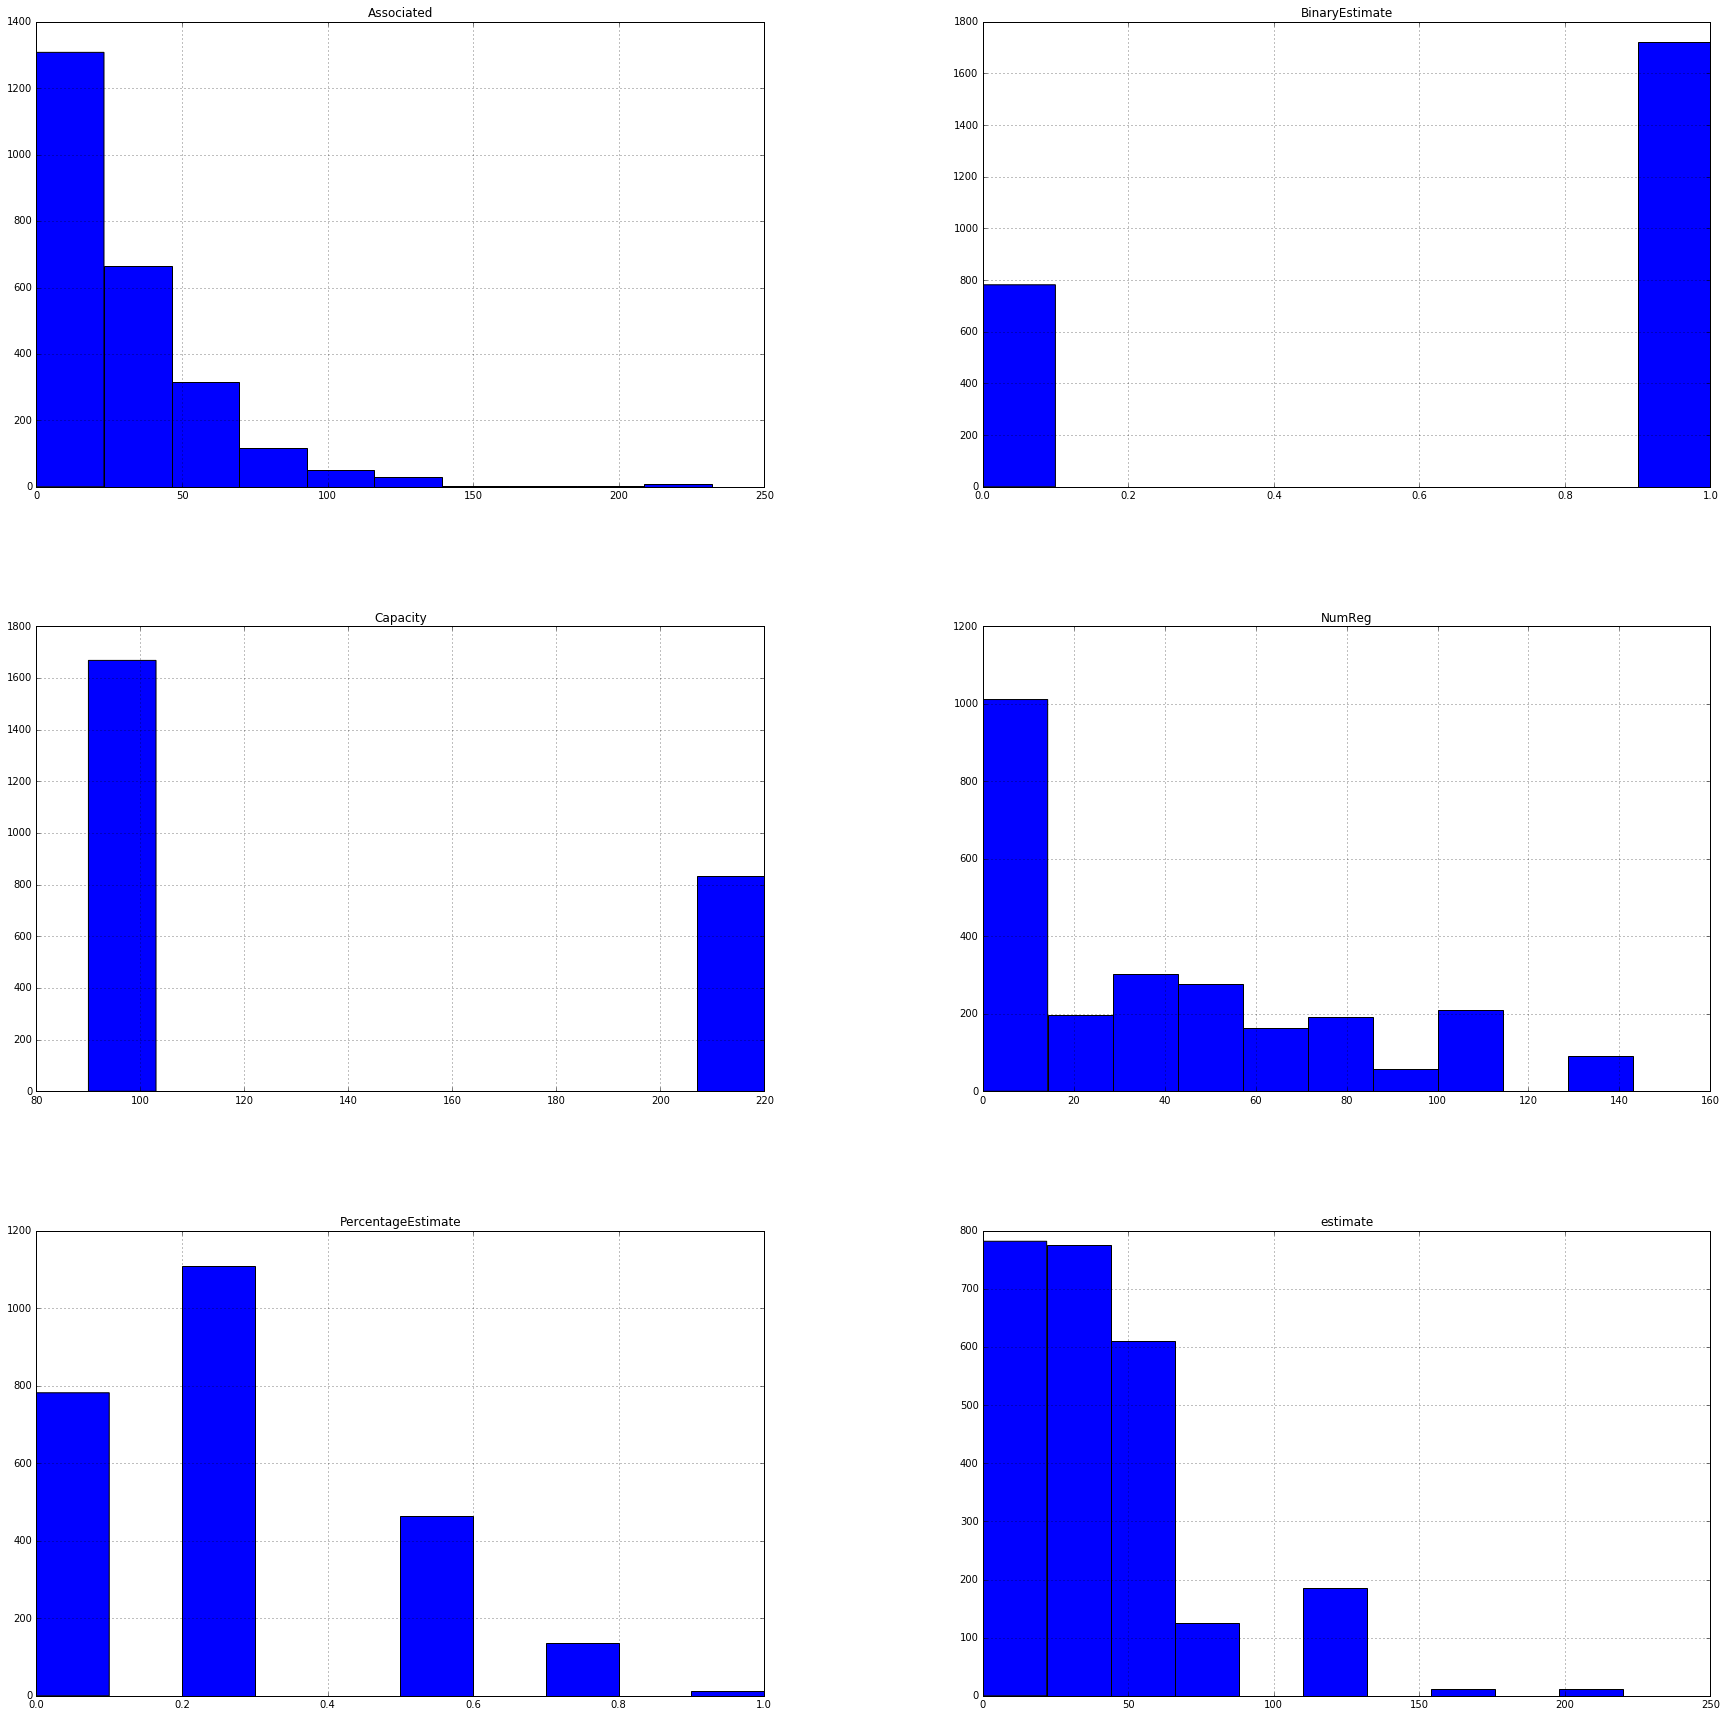

In [19]:
df.hist(figsize = (30,30))

## Type of distribution:
From these plots we can see that the estimated number of people along with the associated count of Wi-Fi connections are positively skewed. To confirm this, we can look at the number of values below the mean value for both these feaures. [2, pp. 76-77]

### Describe numerical features in dataframe

In [20]:
df.describe()

,Capacity,NumReg,Associated,PercentageEstimate,BinaryEstimate,estimate
count,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000
mean,133.333333,38.288569,30.284972,0.249101,0.687450,32.628897
std,61.294838,40.911113,28.965944,0.217957,0.463625,34.702654
min,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,0.000000,10.000000,0.000000,0.000000,0.000000
50%,90.000000,29.000000,22.000000,0.250000,1.000000,22.500000
75%,220.000000,60.000000,42.000000,0.250000,1.000000,55.000000
max,220.000000,143.000000,232.000000,1.000000,1.000000,220.000000


### Find the number of values for estimates

In [21]:
# www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-grouping-data-in-python-pandas
df['estimate'].value_counts()

0.0      782
22.5     776
55.0     332
45.0     278
110.0    185
67.5     125
220.0     12
165.0     12
Name: estimate, dtype: int64

### Find the number of values for associated connections

In [22]:
df['Associated'].value_counts()

14     80
0      77
9      73
15     67
2      66
11     63
7      62
13     59
12     59
6      58
17     52
5      51
10     51
8      51
1      50
3      48
34     48
30     48
16     47
19     46
21     46
23     45
18     43
4      43
28     42
29     42
26     40
22     39
24     38
35     36
       ..
130     2
132     2
124     2
122     2
114     2
112     2
110     2
102     2
90      2
177     1
159     1
133     1
131     1
123     1
121     1
203     1
221     1
119     1
232     1
113     1
107     1
227     1
226     1
224     1
206     1
162     1
126     1
120     1
106     1
229     1
Name: Associated, dtype: int64

### Find the total number of values below the mean for both the estimates and the associated count.

In [23]:
def underOverMean(Feature, mean):
    underMean, overMean = 0, 0
    for i in range(len(df)):
        if Feature[i]<mean:
            underMean +=1
        else:
            overMean+=1
    return (underMean, overMean)
    
    
print('For estimated number of people, values (under mean, over mean): ', underOverMean(df.estimate, 32.628897))
print('For Wi-Fi connections, values (under mean, over mean): ', underOverMean(df.Associated,  30.284972))


For estimated number of people, values (under mean, over mean):  (1558, 944)
For Wi-Fi connections, values (under mean, over mean):  (1576, 926)


## Analysis
Because we can now see that the target feature (and also the associated connections) have a positively skewed distribution instead of a normal distribution [2, pp. 76-77], we cannot use the 68-95-99.7 rule [3, p. 127] so instead we will have to plot the data using box plots in order to identify outliers in the target feature. 

# Identifying outliers - Bloxplots 

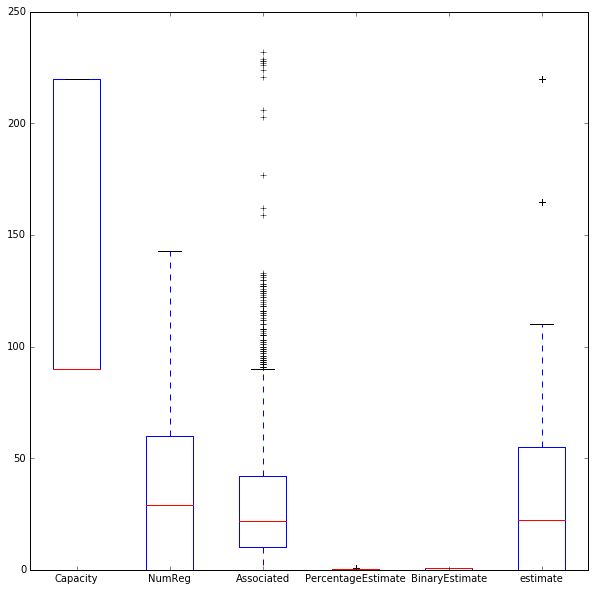

In [24]:
# http://pandas.pydata.org/pandas-docs/version/0.15.0/visualization.html
df.plot(kind = 'box', figsize = (10,10))

The crosses on the boxplot signify possible outliers. In the estimate columns, we can see that there are two areas 
in which there are possuble outliers. These values are roughly over 150 and over 220. To access whether these values
are caused by error or are valid data and then we have to look at how to deal with them. 

In [25]:
over150 = df[(df.estimate>150 )]
over150

,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate,estimate
2,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,124,0.75,1,165.0
5,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,119,0.75,1,165.0
7,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,62,0.75,1,165.0
11,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,68,0.75,1,165.0
14,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,125,0.75,1,165.0
17,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,124,0.75,1,165.0
19,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,95,0.75,1,165.0
22,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,20,0.75,1,165.0
25,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,125,0.75,1,165.0
28,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,122,0.75,1,165.0


There are 24 perceived outliers in this distribution. To understand why these outliers exist, we need to take a look at how the groundtruth data was collected.We know that there were either 25%, 50%, 75% or 100% estimated to be in the room so for the first set of estimates at 165, considering there are 143 people registered in the modules, this is most probably a reasonable estimate of the number of people in the room.  However, when we look at the last 12 rows we can see that there are the same number of people registered in the module, however the room is apparently at full capacity (i.e. 220 people). This is a percieved over-estimation of 76 people meaning that this outlier could potentially be down to human error. Notably, there are also more wifi connections in the last 220 rows however this could be coming from a different room or could come from students having more devices. We could assume also that there were significantly more people in the room on this day, however, given that this is a slot with a certain number of students registered, it is unlikely that there would be 76 extra occupants in the room. To deal with this apparently human error, we can clamp the estimate as the number of students registered for the module as this is more of a realistic maximum estimate of the number of people in the room ffor this particular hour. 

# Modelling techniques

To get an idea of the best fit model for our data, we first looked at a simple linear regression. In order to take a understand whether these this type of model is approprate we can plot the residual values which will indicate the error between the predicted estimate and the actual estimate for the model [1, p.93]. If a linear model is truely a good fit for the data then there should not be a pattern within the residuals plotted however when we do plot these residuals, there are clear patterns which could indicate non-linearity [1, p.93-94]. For this reason, we descided to use logistic regression in order to build a more appropriately fitted model. 

In [31]:
import statsmodels.formula as sm
# http://bigdataexaminer.com/uncategorized/linear-regression-in-python-using-stats-models/
lm = sm.ols(formula="estimate ~  Capacity + NumReg + AverageHour + C(Room)-1 + C(Module)-1 + C(DateTime)-1", data=df).fit()
plt.scatter(lm.predict(df),lm.predict(df)- df.Estimate)
plt.hlines(y = 0, xmin = -50, xmax=250)

AttributeError: 'DataFrame' object has no attribute 'Estimate'

In [ ]:
# http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/regression_diagnostics.html
# from statsmodels.graphics.regressionplots import plot_leverage_resid2
# fig, ax = plt.subplots(figsize=(8,6))
# fig = plot_leverage_resid2(results, ax = ax)

In [ ]:
References
[1]James, Gareth, et al. An introduction to statistical learning. Vol. 6. New York: springer, 2013.
[2] Rubin, Allen. Statistics for evidence-based practice and evaluation. Cengage Learning, 2012.
[3] Shahbaba, Babak. Biostatistics with R: An Introduction to Statistics Through Biological Data. New York: Springer, 2012.



